Single input multi output architecture trained using Transfer learning 
1. Model used - MobileNet
2. Method - Fine tuning
3. Data input size - not fixed
4. With augmentation
5. Training data - Generated data
6. Test data - Cifar100
7. Dependencies from year - 2020

In [1]:
#Loading basic modules
import os
import tensorflow as tf

#This line of code is to counter cuDNN running out of memory for memory intensive tasks and throuwing cuDNN failure
#message, where it would fail to load conv net. Such error led me to restart my kernal over and over again.
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#tf.config.list_physical_devices('GPU')
#from tensorflow.python.platform import build_info as tf_build_info
#print(tf_build_info.cuda_version_number)
#print(tf_build_info.cudnn_version_number)
#import sys
#sys.version

Dependencies

In [2]:
# to visualize our architecture
#using utils plot_model
#conda install pydot
#conda install pydotplus
#conda install graphviz

# Dataset settings

In [3]:
#Loading modules for data processing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, ImageDataGenerator, load_img
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import random
import pandas as pd

In [4]:
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, UpSampling2D
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import optimizers, applications
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
#from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import utils 

from tensorflow.keras.applications import MobileNet

Training and validation data preparation

In [5]:
#function to visulakize images and their labels
def plot_colour_images(images_to_plot, filepath, titles=None, titles2 = None, ncols=10, thefigsize=(25,25)):
    
    n_images = images_to_plot.shape[0]  
    nrows = np.ceil(n_images/ncols).astype(int)
    
    fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
    ax = ax.flatten()

    for i in range(n_images):
        ax[i].imshow( array_to_img(images_to_plot[i,:,:,:])) 
            # cmap=cm.Greys plots in Grey scale so the image looks as if it were written
        ax[i].axis('off')  
        
        if titles is not None and titles2 is not None:
            #ax[i].set_title(titles[i])
            ax[i].set_title(str(int(titles[i]))+' : '+Cifar100_list[int(titles[i])]+
                            '\n' +Recycle_list[int(titles2[i])], fontsize=20)
            
        if titles2 is None:
            ax[i].set_title(str(int(titles[i]))+' : '+Cifar100_list[int(titles[i])], fontsize=20)
            
    #plt.savefig(filepath)

In [6]:
def get_smaller_balanced_data(original_X, original_Y, data_size_needed = 5000, num_of_categories = 100):
    
    '''This function returns balanced and smaller data set extracted from Cifar100'''
    '''I have set no seed as random indexing makes the sampled data random
    data_size_needed = integer - number of samples you want from the population
    num_of_categories = integer - basically number of labels in the data set
    '''
    
    
    x_array = np.zeros((data_size_needed, original_X.shape[1], original_X.shape[2], original_X.shape[3]))
    y_array = np.zeros((data_size_needed,1))
    limit = int(data_size_needed/num_of_categories) 
    
    y = np.unique(original_Y)
    
    for i in range(num_of_categories):
        
        item = original_X[np.where(original_Y == y[i])[0]] #images for each category
        index = random.sample(range(len(item)), limit)  #20 random indices
        
        for idx, num in enumerate(index):               #extracting
            x_array[(i*limit)+idx] = item[num,:,:,:]   
            
        y_array[(i*limit): ((i*limit)+limit)] = y[i]
    
    x_array = x_array.astype('uint8')
    y_array = y_array.astype('int32')
        
    x_array, y_array = shuffle(x_array, y_array)
        
    return x_array, y_array

In [7]:
#Setting file paths for this section
test_image_path = 'C:\\Users\\PC\Desktop\\Term3\\Generated data\\Test'
val_image_path = 'C:\\Users\\PC\Desktop\\Term3\\Generated data\\Validation'


#Importing Cifar100 dataset
from tensorflow.keras.datasets import cifar100
(cx_train, cy_train ),(cx_val, cy_val) = cifar100.load_data(label_mode='fine')

#get small cifar data first
x_train_cifar, y_train = get_smaller_balanced_data(cx_train, cy_train)
x_val_cifar, y_val = get_smaller_balanced_data(cx_val, cy_val)

del cx_train, cy_train

Cifar100_list = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

Recycle_list = ['Don\'t Recycle', 'Recycle']
Recycle_categories = ['apple', 'bottle', 'bowl','can', 'cup','mushroom','orange','pear','plate', 'sweet_pepper']

#Making recycling label data
category_index = [Cifar100_list.index(x) for x in Recycle_categories]
#[0, 9, 10, 16, 28, 51, 53, 57, 61, 83]
#We can treat the rest of the classes as non recyclable items

In [8]:
#Training Data Prep from my original images

'''1. Downloaded images from my phone to my laptop and stored them in folder Test
2. Used online tools (Image Resizer) to resize batches in standardized shape - in this case 224 x 224
2. Within folder Test - each class was stoed in its own folder with name of the folder = class name
that is apple images in 'apple' named folder
3. All images in their respective folders were named class_name_num.jpg
thats is apple_1.jpg


Get-ChildItem -Path C:\\Users\\PC\\Desktop\\Term3\\Test\\apple | % -Begin { $i = 1 } -Process { Rename-Item -LiteralPath $_.FullName -NewName ("apple_{0}.jpg" -f $i++)}

This is the script that i used in powershell to rename all my image batch in the format I wanted for keras
'''
#Using ImageDataGenerator to access data from directory. Returns an object that has images and labels inferred 

def generate_test_data_from_directory(folder_path, image_target_size = 160, batch_size = 5, channels = 3, 
                                      class_mode = 'sparse', list_name = Cifar100_list, category_index = category_index): 
    
    '''fetch all out test data from directory'''
     
    test_datagen = ImageDataGenerator() # rescaling very adversely affected the predictions, 
                                        # whether or not vgg16 preprocessing was used or not
    test_generator = test_datagen.flow_from_directory(
            folder_path ,
            target_size = (image_target_size, image_target_size),
            batch_size  = batch_size,
            class_mode  = class_mode)

    total_images = test_generator.n  #305 in our case
    steps = total_images//batch_size #iterations to cover all data, so if batch is 5, it will take 11 iteration = 55 images

    x , y = [] , []
    for i in range(steps):
        a , b = test_generator.next()
        x.extend(a) 
        y.extend(b)
    
    x_array = np.array(x).astype('uint8')
    y_array = np.array(y).astype('int32').reshape(len(y),1)
    
    '''setting labels that correspond to original data set, 
    as labels generated by the generator are according to 
    how many classes are there in test set'''
    
    labels = test_generator.class_indices
    for i in range(len(y_array)):
        y_array[i]  = list_name.index([(cat_name) for cat_name, label in labels.items() if label == y_array[i]][0])
    
    
    y_recycle = np.zeros(len(y_array))
    y_recycle[np.where(category_index == y_array)[0]] = 1
    y_recycle = y_recycle.astype('int32')
        
    return x_array, y_array, y_recycle

#Now we get generated data
x_train_gene, y_train_gene, _ = generate_test_data_from_directory(test_image_path)
x_val_gene, y_val_gene, _ = generate_test_data_from_directory(val_image_path)

Found 220 images belonging to 11 classes.
Found 96 images belonging to 11 classes.


In [9]:
#Now to add generated data set to cifar data set. As the data set sizes are different, 
#we need to upsacle cifar data set before we could add generated dataset to it

def upscale(x, input_shape = 32, upscale_factor = 5):
    
    inputs = Input(shape =(input_shape, input_shape, 3))
    outputs = UpSampling2D((upscale_factor,upscale_factor), input_shape=(None,input_shape,input_shape,3), interpolation='bilinear')(inputs)
    preprocess = Model(inputs, outputs)
    upscaled_data = preprocess.predict(x)
    
    return upscaled_data

x_train = upscale(x_train_cifar)
x_val = upscale(x_val_cifar)

In [10]:
#as the shape of the two arrays is same now ,we can concatenate these to make our new training
#and validation data
def merge_train_data(x1 ,y1 ,x2,y2, label_list = ['apple', 'baby', 'bowl', 'can', 'chair',
                                                   'clock','cup', 'orange','orchid', 'plate', 'woman'], 
                     list_name = Cifar100_list):
    
    x = np.zeros((x1.shape[0], x1.shape[1], x1.shape[2], x1.shape[3]))
    y = np.zeros((y1.shape[0],1))
    

    for j,i in enumerate(label_list):
        
        idx = list_name.index(i)
        x_1 = x1[np.where(y1 == idx)[0]]
        y_1 = y1[np.where(y1 == idx)[0]]
        
        x_2 = x2[np.where(y2 == idx)[0]]
        y_2 = y2[np.where(y2 == idx)[0]]
        
        '''x1 = np.delete(x1, [np.where(y1 == idx)[0]], axis = 0)
        y1 = np.delete(y1, [np.where(y1 == idx)[0]], axis = 0)
        print(x1.shape)
        '''
        x_1[-(len(x_2)): ] = x_2
        y_1[-(len(y_2)): ] = y_2
        
        x[(j*(len(x_1))): (j*(len(x_1)))+(len(x_1))] = x_1
        y[(j*(len(x_1))): (j*(len(x_1)))+(len(x_1))] = y_1
        
        num = len(label_list) * len(x_1)
        
        
    for j,i in enumerate(list_name):
        
        if i in label_list:
            pass
        else:
            
            x_3 = x1[np.where(y1 == j)[0]]
            y_3 = y1[np.where(y1 == j)[0]]  
            
            x[num : num+(len(x_3))] = x_3
            y[num: num+(len(y_3))] = y_3
            num += len(x_3)
            
    x = x.astype('uint8')
    y = y.astype('int32')
            
    return x, y

x_train, y_train = merge_train_data(x_train ,y_train ,x_train_gene,y_train_gene)
x_val, y_val = merge_train_data(x_val ,y_val ,x_val_gene,y_val_gene)
del x_train_gene,y_train_gene ,x_val_gene,y_val_gene

#even though the datasets are not shiffled now, they will be when we fit the model to these

In [11]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((5000, 160, 160, 3), (5000, 1), (5000, 160, 160, 3), (5000, 1))

In [12]:
#plot_colour_images( x1[680:780,:,:], titles = y1[680:780], titles2 = None ,thefigsize=(25, 25), ncols = 10,
#filepath = None)

In [13]:
#setting recycling labels

y_train_recycle = np.zeros(len(y_train))
y_train_recycle[np.where(category_index == y_train)[0]] = 1
y_train_recycle = y_train_recycle.reshape(len(y_train_recycle),1)
y_train_recycle.shape

(5000, 1)

Test data preparation

In [14]:
#fetch test data
x_val, y_val  = shuffle(x_val, y_val)
x_test , y_test,  = x_val[:2500], y_val[:2500]
x_val, y_val = x_val[2500:], y_val[2500:]

#make test data recycle labels
y_test_recycle = np.zeros(len(y_test))
y_val_recycle = np.zeros(len(y_val))

y_val_recycle[np.where(category_index == y_val)[0]] = 1
y_val_recycle = y_val_recycle.reshape(len(y_val_recycle),1)

y_test_recycle[np.where(category_index == y_test)[0]] = 1
y_test_recycle = y_test_recycle.reshape(len(y_test_recycle),1)

In [15]:
x_val.shape, y_test.shape, y_val_recycle.shape, x_test.shape

((2500, 160, 160, 3), (2500, 1), (2500, 1), (2500, 160, 160, 3))

In [16]:
#plot_colour_images( x_test[0:25,:,:], titles = y_test[0:25], titles2 = None ,thefigsize=(25, 25), ncols = 5,
#filepath = None)

Creating data pipeline

In [17]:
#train_datagen = ImageDataGenerator(**args) # had 12 aug methods - filtered them out
train_datagen = ImageDataGenerator(rotation_range = 45, height_shift_range=0.3, 
                                   zoom_range=0.3, fill_mode ='nearest', brightness_range=(0.1, 0.8), 
                                   channel_shift_range= 55.0, horizontal_flip=True)

# Data augmentation can harm results too. If they are irrelevant, the accuracy of model learning will be very low 
val_datagen = ImageDataGenerator()

#All data sets will be  normalized ( either during model run or in test set case- with pre process function) 
#So, no rescaling has been used here - as its role is redundant

#train_gen = train_datagen.flow(x_train, y_train, batch_size = batch_size) 
#val_gen = val_datagen.flow(x_val, y_val, batch_size = batch_size)  

def train_data_generator(train_datagen, batch_size , x = x_train, y1 = y_train_recycle, y2 = y_train):
    gene_y1 = train_datagen.flow(x, y1, batch_size, seed= 0)
    gene_y2 = train_datagen.flow(x, y2, batch_size, seed = 0)
    #gene_x = train_datagen.flow(y2, seed=0)
    while True:
            #x = gene_x.next()
            y_1 = gene_y1.next()
            y_2 = gene_y2.next()
            yield y_1[0], [y_1[1], y_2[1]]
            
def val_data_generator(val_datagen, batch_size , x = x_val, y1 = y_val_recycle, y2 = y_val):
    #gene_x = val_datagen.flow(x, seed=0)
    gene_y1 = val_datagen.flow(x, y1, batch_size, seed=0)
    gene_y2 = val_datagen.flow(x, y2, batch_size, seed=0)
    while True:
            #x = gene_x.next()
            y_1 = gene_y1.next()
            y_2 = gene_y2.next()
            yield y_1[0], [y_1[1], y_2[1]]

Directory locations for saving files

In [41]:
#Set file paths for this section

#save_augmented_image_path = 'C:\\Users\\PC\\Desktop\\Term3\\Augmented Images'
#save_augmented_val_image_path = 'C:\\Users\\PC\\Desktop\\Term3\\Augmented Images Val'
save_history_path =     r'C:\Users\PC\Desktop\Term3\History\before_ft_history.npy'
save_all_weights_path = r'C:\Users\PC\Desktop\Term3\Weights\before_ft_weights'
save_best_weights =     r'C:\Users\PC\Desktop\Term3\Best weights\before_ft_best_weights_'
save_plot_path1 =        r'C:\Users\PC\Desktop\Term3\Plots\recycle_before_ft_plot.jpg'
save_boxplot_path =     r'C:\Users\PC\Desktop\Term3\Plots\before_ft_boxplot.jpg'
save_model_path =       r'C:\Users\PC\Desktop\Term3\Models\before_ft_model.h5'
save_plot_path2 =        r'C:\Users\PC\Desktop\Term3\Plots\class_before_ft_plot.jpg'

#and other auxillaries for the model
batch_size = 25
learning_rate = 0.001

best_model = ModelCheckpoint(save_best_weights +'save_at_{epoch}.h5', monitor='val_loss', mode='min', 
                             save_best_only=True, verbose = 2)
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose = 0)

# Creating Architecture

In [19]:
#Downloading imagenet weights into mobilenet network without FC layers
input_shape = (160, 160, 3)
mobilenet = MobileNet(include_top = False, weights = 'imagenet', input_shape = input_shape)

mobilenet.trainable = False
for l in mobilenet.layers:
    l.trainable = False


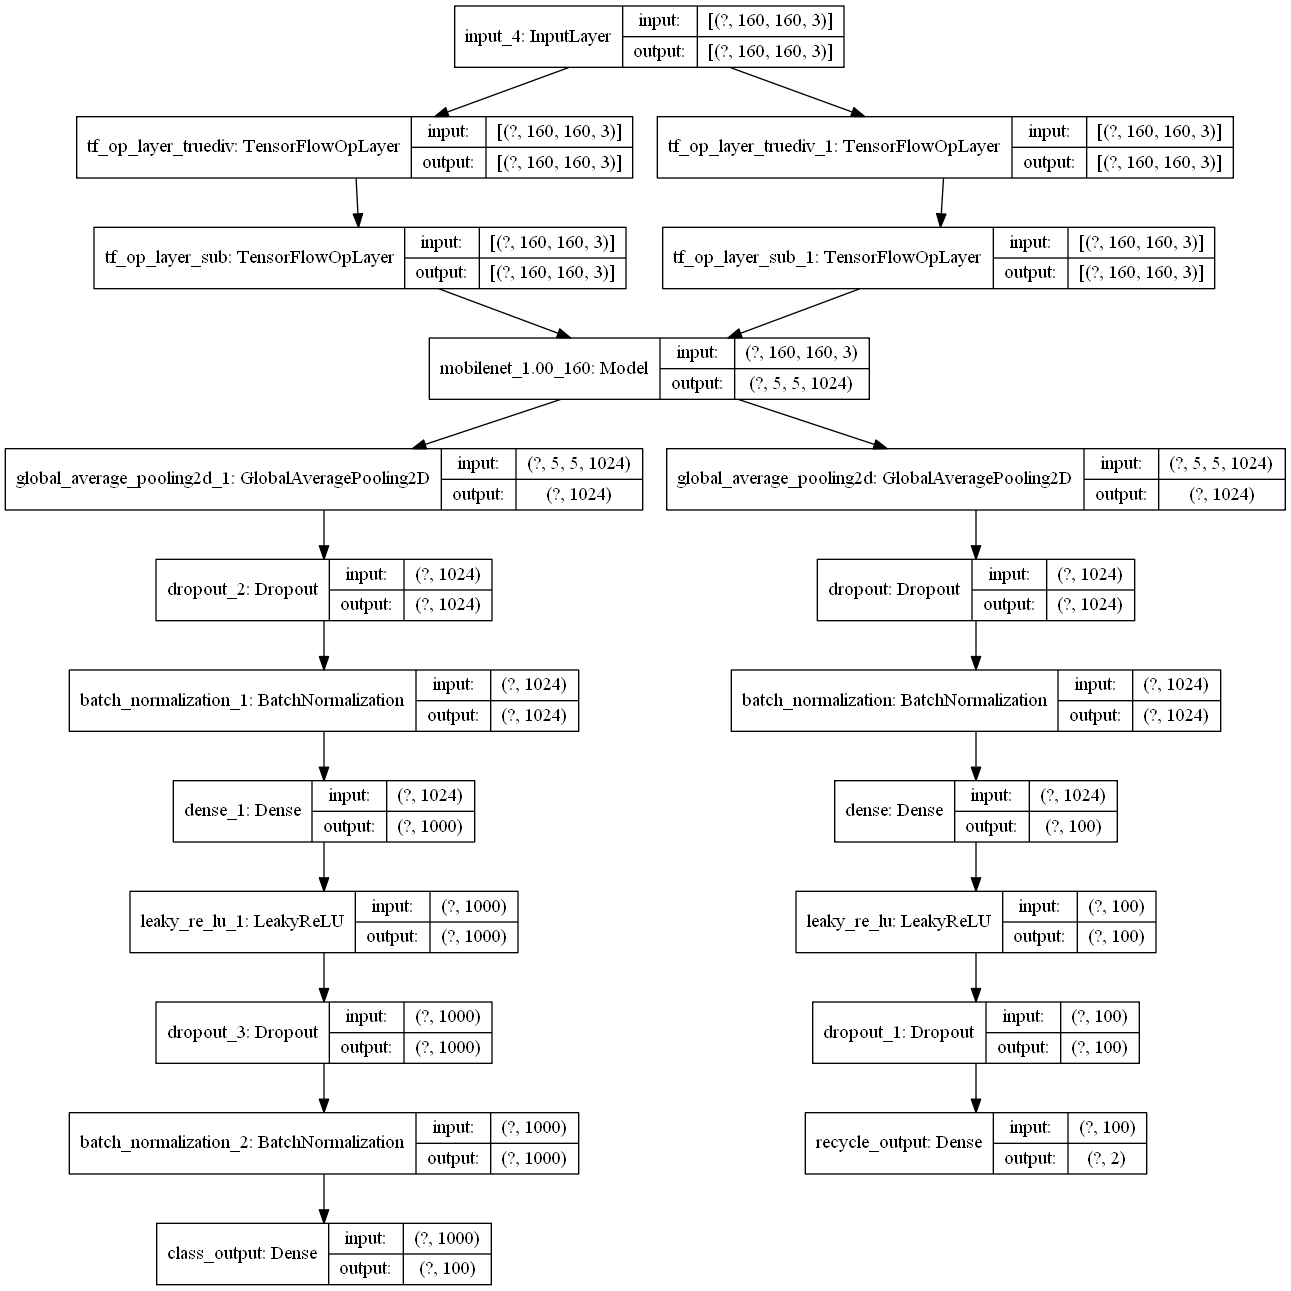

In [20]:
# creating branch 1 - > recycle branch
# https://www.tensorflow.org/guide/keras/train_and_evaluate#the_compile_method_specifying_a_loss_metrics_and_an_optimizer 

inputs = Input(shape=(160, 160, 3))  
recycle = applications.mobilenet.preprocess_input(inputs)
recycle = mobilenet(recycle, training = False)
recycle = GlobalAveragePooling2D()(recycle)
recycle = Dropout(0.5)(recycle)
recycle = BatchNormalization()(recycle)
recycle = Dense(100)(recycle)
recycle = LeakyReLU(0.13)(recycle)
recycle = Dropout(0.2)(recycle)
recycle_output = Dense(2, activation='sigmoid', name="recycle_output")(recycle)

#second branch
classes = applications.mobilenet.preprocess_input(inputs)
classes = mobilenet(classes, training = False)
classes = GlobalAveragePooling2D()(classes)
classes = Dropout(0.5)(classes)
classes = BatchNormalization()(classes)
classes = Dense(1000)(classes)
classes = LeakyReLU(0.13)(classes)
classes = Dropout(0.1)(classes)
classes = BatchNormalization()(classes)
class_output = Dense(100, activation= 'softmax', name="class_output")(classes)

model = Model(inputs = inputs, outputs=[recycle_output, class_output])
utils.plot_model(model, "single_input_multi_output_model_transferlearning.png", show_shapes=True)

In [21]:
#Compile model with two losses and correspomding metrics for the two branches
adam = optimizers.Adam(learning_rate=learning_rate)

model.compile(
    optimizer = adam,
    loss={
        "recycle_output": 'binary_crossentropy',
        "class_output": 'sparse_categorical_crossentropy'
    },
    metrics={
        "recycle_output": 'accuracy',
        "class_output": [SparseTopKCategoricalAccuracy(name='sparse_top_5_categorical_accuracy'), 'accuracy']
    },
)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 160, 160, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_truediv_1 (TensorFl [(None, 160, 160, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 160, 160, 3) 0           tf_op_layer_truediv[0][0]        
____________________________________________________________________________________________

In [22]:
#fitting our model
import timeit
epochs = 100
start = timeit.default_timer()
history = model.fit_generator(train_data_generator(train_datagen, batch_size), validation_data = val_data_generator(val_datagen, batch_size),
                              validation_steps = 2500//batch_size, steps_per_epoch = 5000//batch_size, 
                                  epochs = epochs, 
                                  callbacks = [early_stop, best_model], 
                                  shuffle = True)

stop = timeit.default_timer()
print('Time: ', (stop - start)/60)

np.save(save_history_path, history.history)
model.save_weights(save_all_weights_path)
model.save(save_model_path) 

Instructions for updating:
Please use Model.fit, which supports generators.
Train for 200 steps, validate for 100 steps
Epoch 1/100
199/200 [============================>.] - ETA: 0s - loss: 4.5111 - recycle_output_loss: 0.3136 - class_output_loss: 4.1975 - recycle_output_accuracy: 0.8798 - class_output_sparse_top_5_categorical_accuracy: 0.3160 - class_output_accuracy: 0.1270
Epoch 00001: val_loss improved from inf to 2.78193, saving model to C:\Users\PC\Desktop\Term3\Best weights\before_ft_best_weights_save_at_1.h5
200/200 [==============================] - 89s 446ms/step - loss: 4.5097 - recycle_output_loss: 0.3124 - class_output_loss: 4.1974 - recycle_output_accuracy: 0.8804 - class_output_sparse_top_5_categorical_accuracy: 0.3160 - class_output_accuracy: 0.1268 - val_loss: 2.7819 - val_recycle_output_loss: 0.1636 - val_class_output_loss: 2.6184 - val_recycle_output_accuracy: 0.9414 - val_class_output_sparse_top_5_categorical_accuracy: 0.6796 - val_class_output_accuracy: 0.3424
Epoc

Epoch 11/100
199/200 [============================>.] - ETA: 0s - loss: 2.8253 - recycle_output_loss: 0.1903 - class_output_loss: 2.6350 - recycle_output_accuracy: 0.9319 - class_output_sparse_top_5_categorical_accuracy: 0.6404 - class_output_accuracy: 0.3491
Epoch 00011: val_loss did not improve from 2.05149
200/200 [==============================] - 66s 331ms/step - loss: 2.8278 - recycle_output_loss: 0.1911 - class_output_loss: 2.6368 - recycle_output_accuracy: 0.9317 - class_output_sparse_top_5_categorical_accuracy: 0.6404 - class_output_accuracy: 0.3494 - val_loss: 2.1141 - val_recycle_output_loss: 0.1307 - val_class_output_loss: 1.9834 - val_recycle_output_accuracy: 0.9518 - val_class_output_sparse_top_5_categorical_accuracy: 0.8028 - val_class_output_accuracy: 0.4800
Epoch 12/100
199/200 [============================>.] - ETA: 0s - loss: 2.7943 - recycle_output_loss: 0.1824 - class_output_loss: 2.6119 - recycle_output_accuracy: 0.9373 - class_output_sparse_top_5_categorical_accu

199/200 [============================>.] - ETA: 0s - loss: 2.6486 - recycle_output_loss: 0.1686 - class_output_loss: 2.4800 - recycle_output_accuracy: 0.9400 - class_output_sparse_top_5_categorical_accuracy: 0.6649 - class_output_accuracy: 0.3707
Epoch 00021: val_loss did not improve from 1.91487
200/200 [==============================] - 63s 317ms/step - loss: 2.6480 - recycle_output_loss: 0.1690 - class_output_loss: 2.4790 - recycle_output_accuracy: 0.9397 - class_output_sparse_top_5_categorical_accuracy: 0.6656 - class_output_accuracy: 0.3710 - val_loss: 1.9307 - val_recycle_output_loss: 0.1275 - val_class_output_loss: 1.8031 - val_recycle_output_accuracy: 0.9568 - val_class_output_sparse_top_5_categorical_accuracy: 0.8088 - val_class_output_accuracy: 0.5296
Epoch 22/100
199/200 [============================>.] - ETA: 0s - loss: 2.6229 - recycle_output_loss: 0.1710 - class_output_loss: 2.4519 - recycle_output_accuracy: 0.9390 - class_output_sparse_top_5_categorical_accuracy: 0.6760 

199/200 [============================>.] - ETA: 0s - loss: 2.5057 - recycle_output_loss: 0.1690 - class_output_loss: 2.3367 - recycle_output_accuracy: 0.9415 - class_output_sparse_top_5_categorical_accuracy: 0.6949 - class_output_accuracy: 0.4020
Epoch 00031: val_loss improved from 1.84714 to 1.81531, saving model to C:\Users\PC\Desktop\Term3\Best weights\before_ft_best_weights_save_at_31.h5
200/200 [==============================] - 63s 314ms/step - loss: 2.5077 - recycle_output_loss: 0.1686 - class_output_loss: 2.3391 - recycle_output_accuracy: 0.9418 - class_output_sparse_top_5_categorical_accuracy: 0.6938 - class_output_accuracy: 0.4012 - val_loss: 1.8153 - val_recycle_output_loss: 0.1069 - val_class_output_loss: 1.7084 - val_recycle_output_accuracy: 0.9584 - val_class_output_sparse_top_5_categorical_accuracy: 0.8300 - val_class_output_accuracy: 0.5396
Epoch 32/100
199/200 [============================>.] - ETA: 0s - loss: 2.4875 - recycle_output_loss: 0.1701 - class_output_loss: 2

199/200 [============================>.] - ETA: 0s - loss: 2.4023 - recycle_output_loss: 0.1564 - class_output_loss: 2.2460 - recycle_output_accuracy: 0.9453 - class_output_sparse_top_5_categorical_accuracy: 0.7114 - class_output_accuracy: 0.4157
Epoch 00041: val_loss did not improve from 1.76704
200/200 [==============================] - 62s 308ms/step - loss: 2.4003 - recycle_output_loss: 0.1559 - class_output_loss: 2.2444 - recycle_output_accuracy: 0.9456 - class_output_sparse_top_5_categorical_accuracy: 0.7114 - class_output_accuracy: 0.4162 - val_loss: 1.8654 - val_recycle_output_loss: 0.1124 - val_class_output_loss: 1.7529 - val_recycle_output_accuracy: 0.9596 - val_class_output_sparse_top_5_categorical_accuracy: 0.8300 - val_class_output_accuracy: 0.5372
Epoch 42/100
199/200 [============================>.] - ETA: 0s - loss: 2.4068 - recycle_output_loss: 0.1591 - class_output_loss: 2.2477 - recycle_output_accuracy: 0.9425 - class_output_sparse_top_5_categorical_accuracy: 0.7142 

Epoch 52/100
199/200 [============================>.] - ETA: 0s - loss: 2.3821 - recycle_output_loss: 0.1604 - class_output_loss: 2.2217 - recycle_output_accuracy: 0.9446 - class_output_sparse_top_5_categorical_accuracy: 0.7228 - class_output_accuracy: 0.4223
Epoch 00052: val_loss did not improve from 1.76704
200/200 [==============================] - 63s 314ms/step - loss: 2.3857 - recycle_output_loss: 0.1603 - class_output_loss: 2.2255 - recycle_output_accuracy: 0.9447 - class_output_sparse_top_5_categorical_accuracy: 0.7222 - class_output_accuracy: 0.4218 - val_loss: 1.8213 - val_recycle_output_loss: 0.1164 - val_class_output_loss: 1.7049 - val_recycle_output_accuracy: 0.9576 - val_class_output_sparse_top_5_categorical_accuracy: 0.8292 - val_class_output_accuracy: 0.5448
Epoch 53/100
199/200 [============================>.] - ETA: 0s - loss: 2.3620 - recycle_output_loss: 0.1568 - class_output_loss: 2.2052 - recycle_output_accuracy: 0.9443 - class_output_sparse_top_5_categorical_accu

# Testing on model weights

In [48]:
from sklearn.metrics import accuracy_score
from IPython.display import display
#model = load_model(saved_model_path)

In [25]:
results = model.predict(x_test)

In [50]:
recyclce_precictions = np.argmax(results[0], axis = 1)
recyclce_precictions = recyclce_precictions.reshape(2500,1)

In [51]:
accuracy_recycle  = accuracy_score(y_test_recycle, recyclce_precictions )
accuracy_recycle

0.4112

In [52]:
class_precictions = np.argmax(results[1], axis = 1)
class_precictions = class_precictions.reshape(2500,1)

In [53]:
accuracy_class  = accuracy_score(y_test, class_precictions )
accuracy_class

0.5364

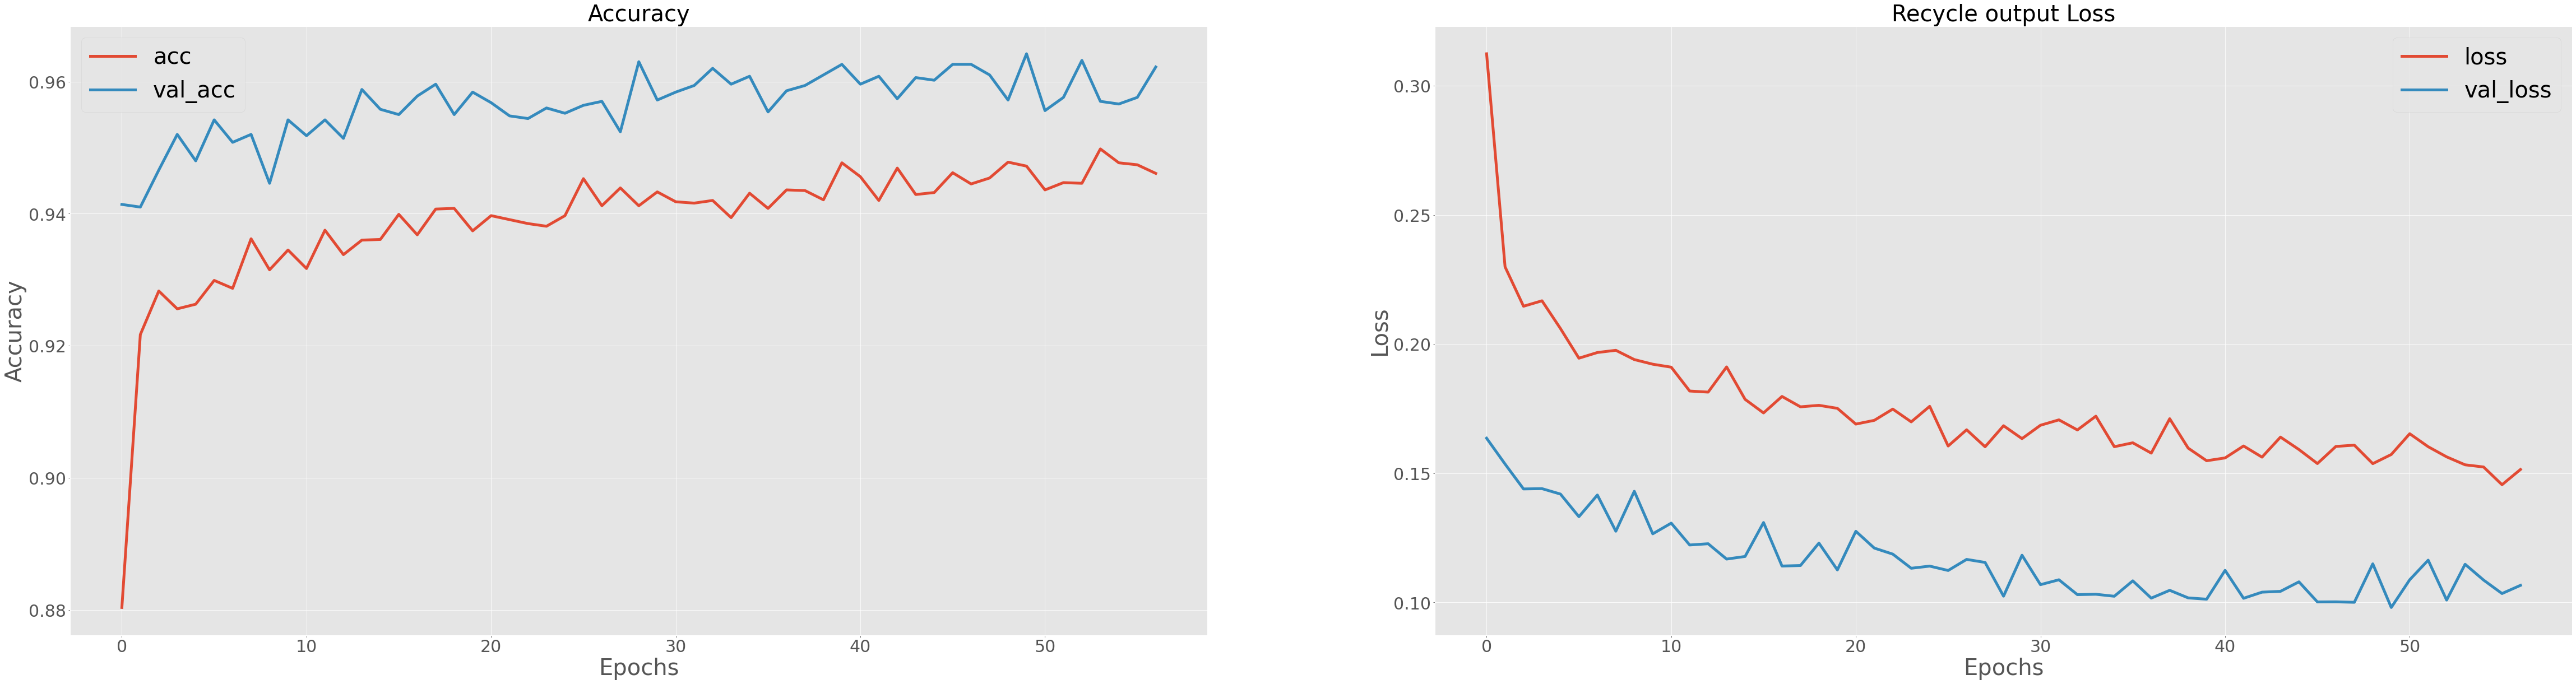

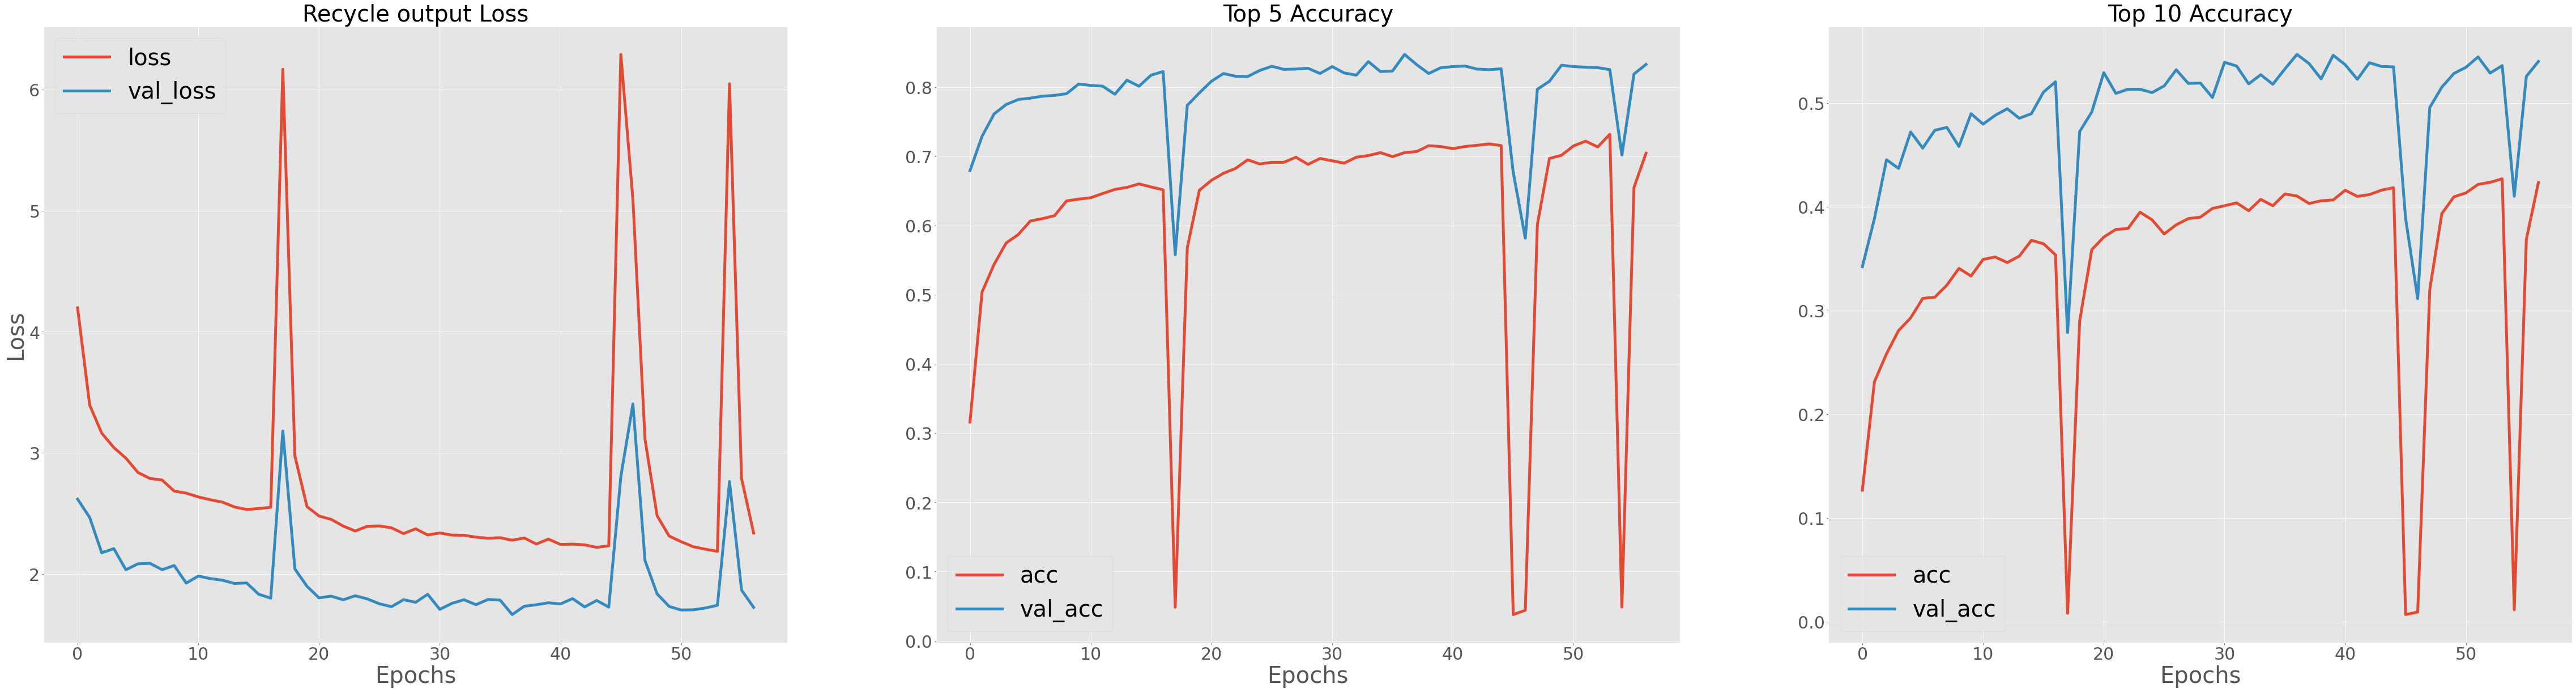

In [43]:
History=np.load(save_history_path ,allow_pickle='TRUE').item()
#History.keys()

plt.style.use("ggplot")
fig,axes = plt.subplots(nrows=1, ncols=2,figsize = (80,20) )

axes[0].plot(History['recycle_output_accuracy'], label = 'acc', linewidth=5)
axes[0].plot(History['val_recycle_output_accuracy'], label='val_acc', linewidth=5)
axes[0].tick_params(labelsize=30)
axes[0].set_title('Accuracy', fontsize=40)
axes[0].set_xlabel("Epochs", fontsize=40)
axes[0].set_ylabel("Accuracy", fontsize=40)
axes[0].legend(fontsize=40)

axes[1].plot(History['recycle_output_loss'], label = 'loss', linewidth=5)
axes[1].plot(History['val_recycle_output_loss'], label='val_loss', linewidth=5)
axes[1].tick_params(labelsize=30)
axes[1].set_title('Recycle output Loss', fontsize=40)
axes[1].set_xlabel("Epochs", fontsize=40)
axes[1].set_ylabel("Loss", fontsize=40)
axes[1].legend(fontsize=40)
fig.savefig(save_plot_path1)

fig,axes = plt.subplots(nrows=1, ncols=3,figsize = (80,20) )

axes[1].plot(History['class_output_sparse_top_5_categorical_accuracy'], label = 'acc', linewidth=5)
axes[1].plot(History['val_class_output_sparse_top_5_categorical_accuracy'], label='val_acc', linewidth=5)
axes[1].tick_params(labelsize=30)
axes[1].set_title('Top 5 Accuracy', fontsize=40)
axes[1].set_xlabel("Epochs", fontsize=40)
axes[1].legend(fontsize=40)

axes[2].plot(History['class_output_accuracy'], label = 'acc', linewidth=5)
axes[2].plot(History['val_class_output_accuracy'], label='val_acc', linewidth=5)
axes[2].tick_params(labelsize=30)
axes[2].set_title('Top 10 Accuracy', fontsize=40)
axes[2].set_xlabel("Epochs", fontsize=40)
axes[2].legend(fontsize=40)

axes[0].plot(History['class_output_loss'], label = 'loss', linewidth=5)
axes[0].plot(History['val_class_output_loss'], label='val_loss', linewidth=5)
axes[0].tick_params(labelsize=30)
axes[0].set_title('Recycle output Loss', fontsize=40)
axes[0].set_xlabel("Epochs", fontsize=40)
axes[0].set_ylabel("Loss", fontsize=40)
axes[0].legend(fontsize=40)



fig.savefig(save_plot_path2)

plt.show()

# Fine Tuning

In [54]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 160, 160, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_truediv_1 (TensorFl [(None, 160, 160, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 160, 160, 3) 0           tf_op_layer_truediv[0][0]        
____________________________________________________________________________________________

In [55]:
#Set file paths for this section

#save_augmented_image_path = 'C:\\Users\\PC\\Desktop\\Term3\\Augmented Images'
#save_augmented_val_image_path = 'C:\\Users\\PC\\Desktop\\Term3\\Augmented Images Val'
save_history_path =     r'C:\Users\PC\Desktop\Term3\History\after_ft_history.npy'
save_all_weights_path = r'C:\Users\PC\Desktop\Term3\Weights\after_ft_weights'
save_best_weights =     r'C:\Users\PC\Desktop\Term3\Best weights\after_ft_best_weights_'
save_plot_path1 =        r'C:\Users\PC\Desktop\Term3\Plots\recycle_after_ft_plot.jpg'
save_boxplot_path =     r'C:\Users\PC\Desktop\Term3\Plots\after_ft_boxplot.jpg'
save_model_path =       r'C:\Users\PC\Desktop\Term3\Models\after_ft_model.h5'
save_plot_path2 =        r'C:\Users\PC\Desktop\Term3\Plots\class_after_ft_plot.jpg'

#and other auxillaries for the model
batch_size = 25

In [56]:
#Code taken from Fchollet deep learning 
#We unfreeze some blocks or layers inthe model so that theuy may be fine tuned 


mobilenet.trainable = True

'''set_trainable = False
for layer in vgg.layers:
    if layer.name in ['block5_conv1']:    # 'block4_conv1'
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        '''

for layer in mobilenet.layers[:62]:
    layer.trainable = False

#layers = [(layer, layer.name, layer.trainable) for layer in mobilenet.layers]
#pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

In [57]:
mobilenet.summary()

Model: "mobilenet_1.00_160"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 161, 161, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 80, 80, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 80, 80, 32) 

In [58]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 160, 160, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_truediv_1 (TensorFl [(None, 160, 160, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 160, 160, 3) 0           tf_op_layer_truediv[0][0]        
____________________________________________________________________________________________

In [59]:
model.compile(
    optimizer = optimizers.Adam(lr=1e-5),
    loss={
        "recycle_output": 'binary_crossentropy',
        "class_output": 'sparse_categorical_crossentropy'
    },
    metrics={
        "recycle_output": 'accuracy',
        "class_output": [SparseTopKCategoricalAccuracy(name='sparse_top_5_categorical_accuracy'), 'accuracy']
    },
)

In [61]:
import timeit
start = timeit.default_timer()

history = model.fit_generator(train_data_generator(train_datagen, batch_size), validation_data = val_data_generator(val_datagen, batch_size),
                              validation_steps = 2500//batch_size, steps_per_epoch = 5000//batch_size, 
                                  epochs = 50, 
                                  callbacks = [early_stop, best_model], 
                                  shuffle = True)

stop = timeit.default_timer()
print('Time: ', (stop - start)/60)

np.save(save_history_path,history.history)
model.save_weights(save_all_weights_path)
model.save(save_model_path)

Train for 200 steps, validate for 100 steps
Epoch 1/50
199/200 [============================>.] - ETA: 0s - loss: 2.3318 - recycle_output_loss: 0.1572 - class_output_loss: 2.1745 - recycle_output_accuracy: 0.9450 - class_output_sparse_top_5_categorical_accuracy: 0.7427 - class_output_accuracy: 0.4382
Epoch 00001: val_loss improved from inf to 1.85586, saving model to C:\Users\PC\Desktop\Term3\Best weights\before_ft_best_weights_save_at_1.h5
200/200 [==============================] - 220s 1s/step - loss: 2.3342 - recycle_output_loss: 0.1573 - class_output_loss: 2.1769 - recycle_output_accuracy: 0.9451 - class_output_sparse_top_5_categorical_accuracy: 0.7418 - class_output_accuracy: 0.4374 - val_loss: 1.8559 - val_recycle_output_loss: 0.1064 - val_class_output_loss: 1.7495 - val_recycle_output_accuracy: 0.9606 - val_class_output_sparse_top_5_categorical_accuracy: 0.8244 - val_class_output_accuracy: 0.5328
Epoch 2/50
199/200 [============================>.] - ETA: 0s - loss: 2.2615 - recy

199/200 [============================>.] - ETA: 0s - loss: 2.0835 - recycle_output_loss: 0.1428 - class_output_loss: 1.9407 - recycle_output_accuracy: 0.9488 - class_output_sparse_top_5_categorical_accuracy: 0.7829 - class_output_accuracy: 0.4846
Epoch 00011: val_loss did not improve from 1.78486
200/200 [==============================] - 103s 513ms/step - loss: 2.0830 - recycle_output_loss: 0.1435 - class_output_loss: 1.9395 - recycle_output_accuracy: 0.9487 - class_output_sparse_top_5_categorical_accuracy: 0.7832 - class_output_accuracy: 0.4850 - val_loss: 1.8164 - val_recycle_output_loss: 0.0979 - val_class_output_loss: 1.7185 - val_recycle_output_accuracy: 0.9626 - val_class_output_sparse_top_5_categorical_accuracy: 0.8340 - val_class_output_accuracy: 0.5404
Epoch 12/50
199/200 [============================>.] - ETA: 0s - loss: 2.0887 - recycle_output_loss: 0.1340 - class_output_loss: 1.9547 - recycle_output_accuracy: 0.9526 - class_output_sparse_top_5_categorical_accuracy: 0.7887 

199/200 [============================>.] - ETA: 0s - loss: 1.9854 - recycle_output_loss: 0.1217 - class_output_loss: 1.8637 - recycle_output_accuracy: 0.9537 - class_output_sparse_top_5_categorical_accuracy: 0.8000 - class_output_accuracy: 0.5104
Epoch 00021: val_loss did not improve from 1.72166
200/200 [==============================] - 99s 495ms/step - loss: 1.9855 - recycle_output_loss: 0.1218 - class_output_loss: 1.8637 - recycle_output_accuracy: 0.9535 - class_output_sparse_top_5_categorical_accuracy: 0.8000 - class_output_accuracy: 0.5100 - val_loss: 3.1321 - val_recycle_output_loss: 0.1031 - val_class_output_loss: 3.0289 - val_recycle_output_accuracy: 0.9638 - val_class_output_sparse_top_5_categorical_accuracy: 0.6816 - val_class_output_accuracy: 0.4520
Epoch 22/50
199/200 [============================>.] - ETA: 0s - loss: 1.9920 - recycle_output_loss: 0.1373 - class_output_loss: 1.8547 - recycle_output_accuracy: 0.9517 - class_output_sparse_top_5_categorical_accuracy: 0.8076 -

199/200 [============================>.] - ETA: 0s - loss: 1.8942 - recycle_output_loss: 0.1259 - class_output_loss: 1.7683 - recycle_output_accuracy: 0.9552 - class_output_sparse_top_5_categorical_accuracy: 0.8149 - class_output_accuracy: 0.5337
Epoch 00031: val_loss improved from 1.69136 to 1.64981, saving model to C:\Users\PC\Desktop\Term3\Best weights\before_ft_best_weights_save_at_31.h5
200/200 [==============================] - 71s 357ms/step - loss: 1.8961 - recycle_output_loss: 0.1255 - class_output_loss: 1.7705 - recycle_output_accuracy: 0.9554 - class_output_sparse_top_5_categorical_accuracy: 0.8140 - class_output_accuracy: 0.5336 - val_loss: 1.6498 - val_recycle_output_loss: 0.0876 - val_class_output_loss: 1.5622 - val_recycle_output_accuracy: 0.9654 - val_class_output_sparse_top_5_categorical_accuracy: 0.8524 - val_class_output_accuracy: 0.5736
Epoch 32/50
199/200 [============================>.] - ETA: 0s - loss: 1.8855 - recycle_output_loss: 0.1218 - class_output_loss: 1.

199/200 [============================>.] - ETA: 0s - loss: 1.8357 - recycle_output_loss: 0.1236 - class_output_loss: 1.7121 - recycle_output_accuracy: 0.9549 - class_output_sparse_top_5_categorical_accuracy: 0.8273 - class_output_accuracy: 0.5506
Epoch 00041: val_loss did not improve from 1.60822
200/200 [==============================] - 99s 494ms/step - loss: 1.8352 - recycle_output_loss: 0.1231 - class_output_loss: 1.7120 - recycle_output_accuracy: 0.9551 - class_output_sparse_top_5_categorical_accuracy: 0.8274 - class_output_accuracy: 0.5504 - val_loss: 1.6514 - val_recycle_output_loss: 0.0997 - val_class_output_loss: 1.5518 - val_recycle_output_accuracy: 0.9576 - val_class_output_sparse_top_5_categorical_accuracy: 0.8544 - val_class_output_accuracy: 0.5804
Epoch 42/50
199/200 [============================>.] - ETA: 0s - loss: 1.8418 - recycle_output_loss: 0.1242 - class_output_loss: 1.7176 - recycle_output_accuracy: 0.9588 - class_output_sparse_top_5_categorical_accuracy: 0.8279 -

# Testing

# Testing on model weights

In [62]:
results = model.predict(x_test)
recyclce_precictions = np.argmax(results[0], axis = 1)
recyclce_precictions = recyclce_precictions.reshape(2500,1)

accuracy_recycle  = accuracy_score(y_test_recycle, recyclce_precictions )
accuracy_recycle

0.4888

In [63]:
class_precictions = np.argmax(results[1], axis = 1)
class_precictions = class_precictions.reshape(2500,1)

accuracy_class  = accuracy_score(y_test, class_precictions )
accuracy_class

0.564

(20, 100)
(20, 1)
(28, 100)
(28, 1)
(24, 100)
(24, 1)
(25, 100)
(25, 1)
(27, 100)
(27, 1)
(23, 100)
(23, 1)
(27, 100)
(27, 1)
(28, 100)
(28, 1)
(23, 100)
(23, 1)
(27, 100)
(27, 1)
(26, 100)
(26, 1)
(32, 100)
(32, 1)
(23, 100)
(23, 1)
(23, 100)
(23, 1)
(33, 100)
(33, 1)
(27, 100)
(27, 1)
(22, 100)
(22, 1)
(25, 100)
(25, 1)
(24, 100)
(24, 1)
(33, 100)
(33, 1)
(25, 100)
(25, 1)
(31, 100)
(31, 1)
(26, 100)
(26, 1)
(29, 100)
(29, 1)
(19, 100)
(19, 1)
(26, 100)
(26, 1)
(23, 100)
(23, 1)
(26, 100)
(26, 1)
(25, 100)
(25, 1)
(27, 100)
(27, 1)
(26, 100)
(26, 1)
(32, 100)
(32, 1)
(23, 100)
(23, 1)
(23, 100)
(23, 1)
(27, 100)
(27, 1)
(24, 100)
(24, 1)
(20, 100)
(20, 1)
(23, 100)
(23, 1)
(25, 100)
(25, 1)
(21, 100)
(21, 1)
(25, 100)
(25, 1)
(23, 100)
(23, 1)
(30, 100)
(30, 1)
(24, 100)
(24, 1)
(26, 100)
(26, 1)
(24, 100)
(24, 1)
(18, 100)
(18, 1)
(23, 100)
(23, 1)
(31, 100)
(31, 1)
(22, 100)
(22, 1)
(27, 100)
(27, 1)
(19, 100)
(19, 1)
(22, 100)
(22, 1)
(22, 100)
(22, 1)
(20, 100)
(20, 1)
(24, 100)


Text(0.5, 1.0, 'Entropy after fine tuning')

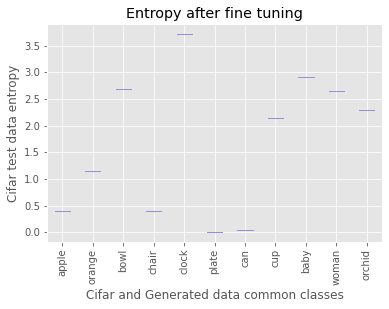

In [93]:
from scipy.stats import entropy


ent_cifar = {}
for i in range(len(Cifar100_list)):
    
    class_image = x_test[np.where(y_test == i)[0]]
    #class_image = applications.mobilenet.preprocess_input(class_image)
    predictions = model.predict(class_image)
    entropy_class = (entropy(predictions[1], axis =1)).reshape( predictions[1].shape[0],1)
    ent_cifar[Cifar100_list[i]] = list(entropy_class[0])
    

entropy_data = pd.DataFrame(data = ent_cifar)
entropy_data.boxplot(['apple','orange','bowl','chair','clock','plate','can','cup', 'baby','woman','orchid'])
plt.xticks(rotation = 90)
plt.xlabel('Cifar and Generated data common classes')
plt.ylabel('Cifar test data entropy')
plt.title('Entropy after fine tuning')
#plt.savefig(save_boxplot_path1)

In [65]:
def top_n_test_accuracy(pred = results[1] , n = 5,  y_test = y_test):
    
    index = np.argsort(pred, axis=1)
    top_n = np.take(index, np.arange(-1,-n-1,-1), axis = 1)
    correct = 0
    failed_index = []
    for i in range(len(pred)):
        if y_test[i] in top_n[i].tolist():
            correct += 1

        if y_test[i] not in top_n[i].tolist():
            failed_index.append(i)

    top_n_accuracy = correct/len(y_test)
    
    return top_n_accuracy, top_n, failed_index

In [66]:
top_n_accuracy, top_n, failed_index = top_n_test_accuracy()
top_n_accuracy

0.8392

In [141]:
titles_of_top_5 = [[Cifar100_list[x] for x in top_n[i]] for i in range(len(top_n))]
titles_of_top_5 = np.array(titles_of_top_5)


In [159]:
def plot_colour_images(images_to_plot, filepath, titles=None, titles2 = None, ncols=10, thefigsize=(25,25)):
    
    n_images = images_to_plot.shape[0]  
    nrows = np.ceil(n_images/ncols).astype(int)
    
    fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
    ax = ax.flatten()

    for i in range(n_images):
        ax[i].imshow( array_to_img(images_to_plot[i,:,:,:])) 
            # cmap=cm.Greys plots in Grey scale so the image looks as if it were written
        ax[i].axis('off')  
        
        if titles is not None and titles2 is not None:
            #ax[i].set_title(titles[i])
            ax[i].set_title(str(int(titles[i]))+' : '+Cifar100_list[int(titles[i])]+
                            '\n' +Cifar100_list[int(titles2[i][0])]+','
                            +Cifar100_list[int(titles2[i][1])]+','
                            +Cifar100_list[int(titles2[i][2])]+',\n'
                            +Cifar100_list[int(titles2[i][3])]+',' 
                            +Cifar100_list[int(titles2[i][4])], fontsize=20)
            
        if titles2 is None:
            ax[i].set_title(str(int(titles[i]))+' : '+Cifar100_list[int(titles[i])], fontsize=20)
            
    plt.savefig(filepath)

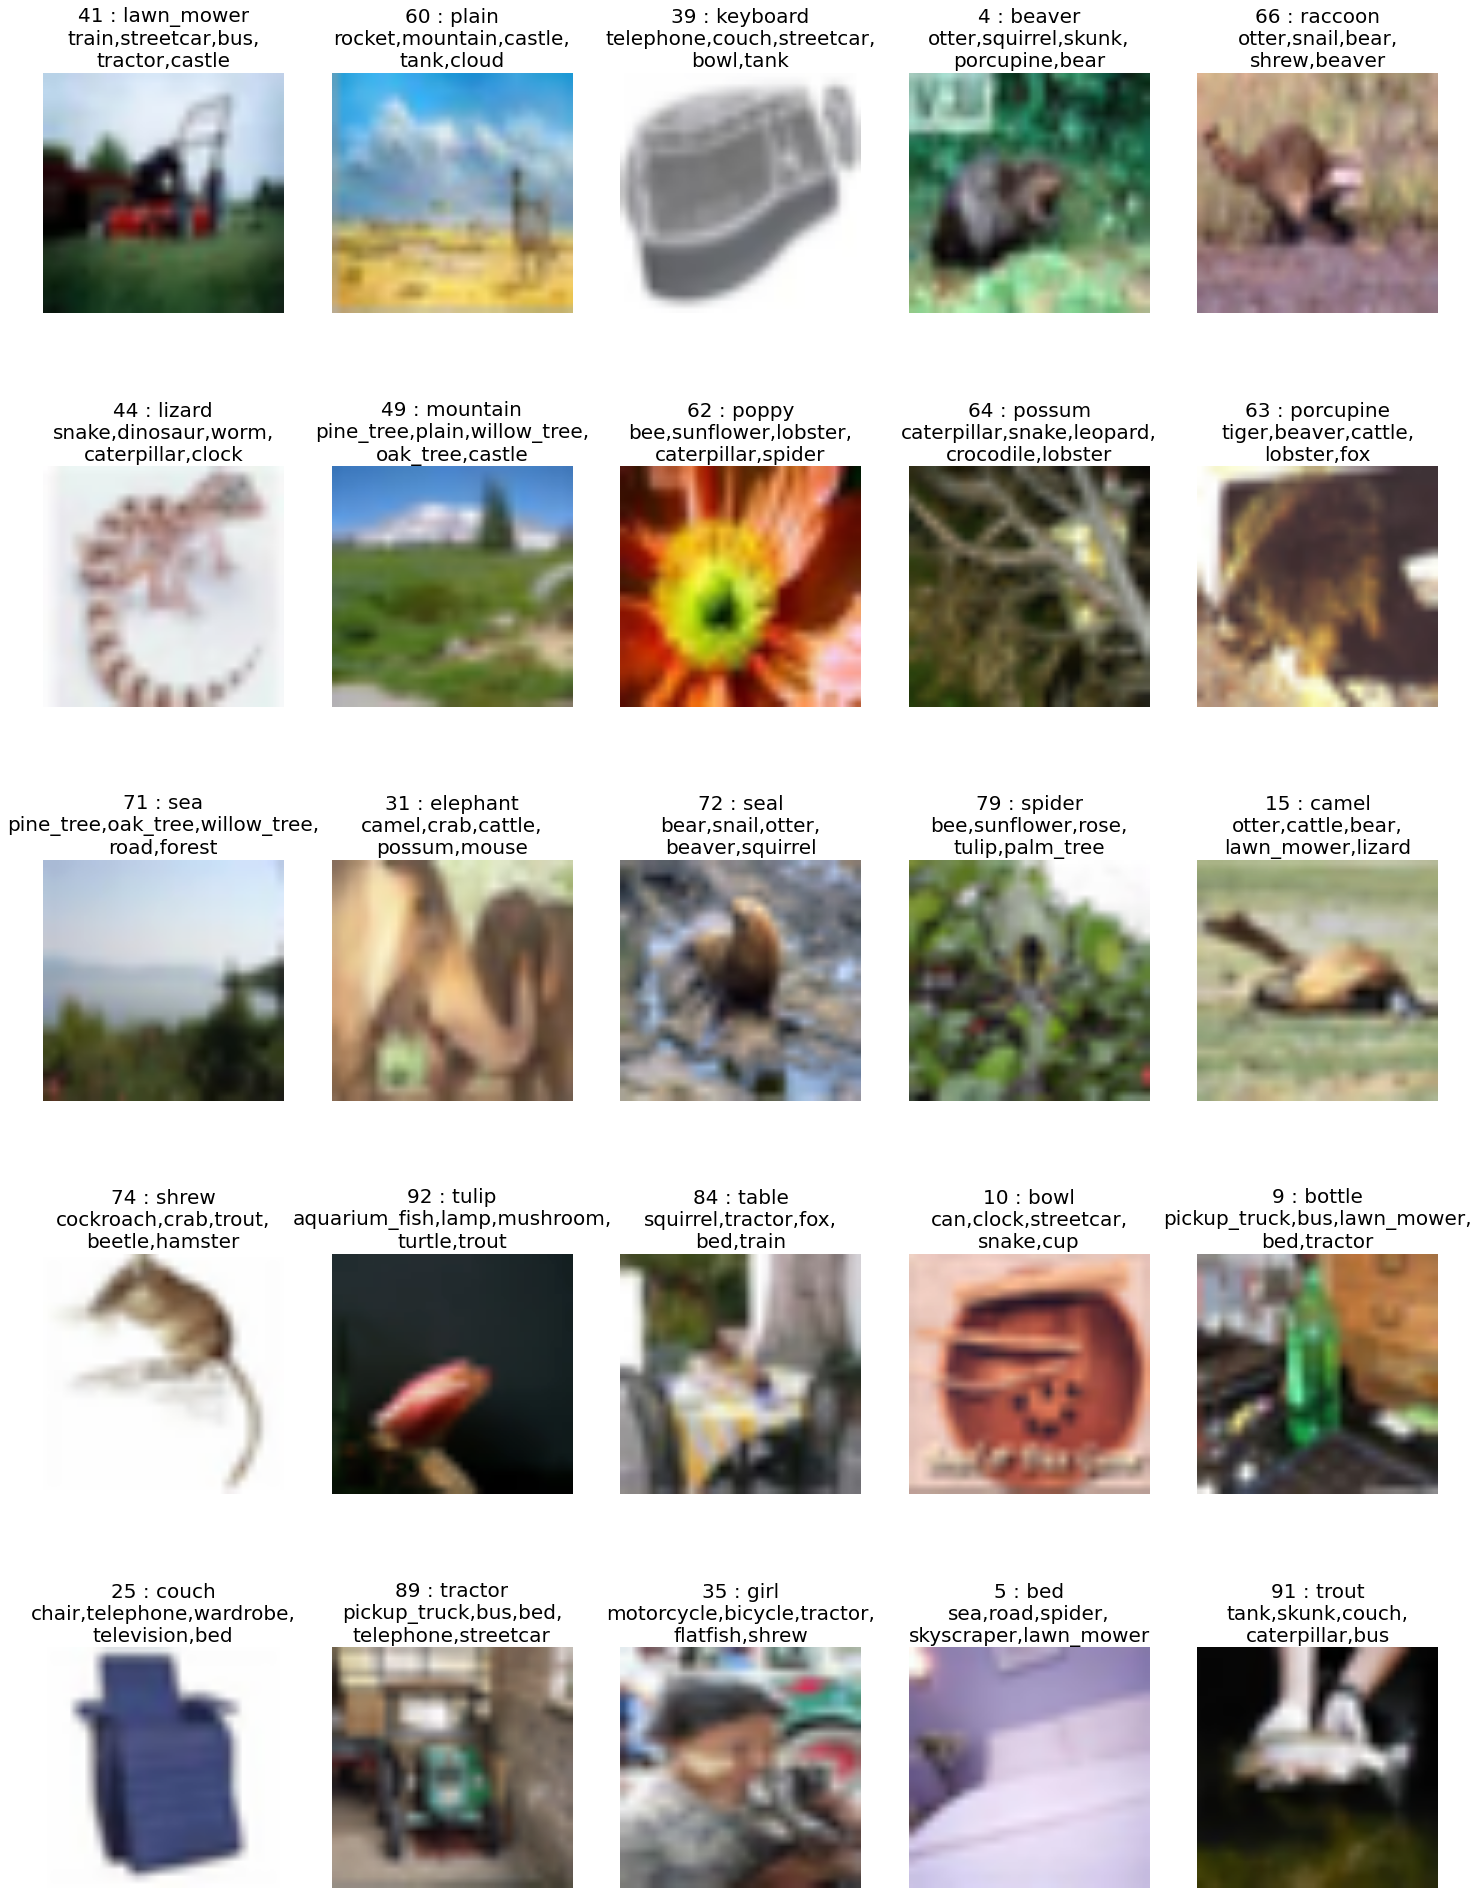

In [160]:
idx = failed_index[0:25]
plot_colour_images( x_test[idx[0:25]], titles = y_test[idx[0:25]], titles2 = top_n[idx[0:25]], 
                   ncols = 5, thefigsize=(25,35), filepath = r'C:\Users\PC\Desktop\Term3\Plots\failed_prediction_of_final_model.jpg')

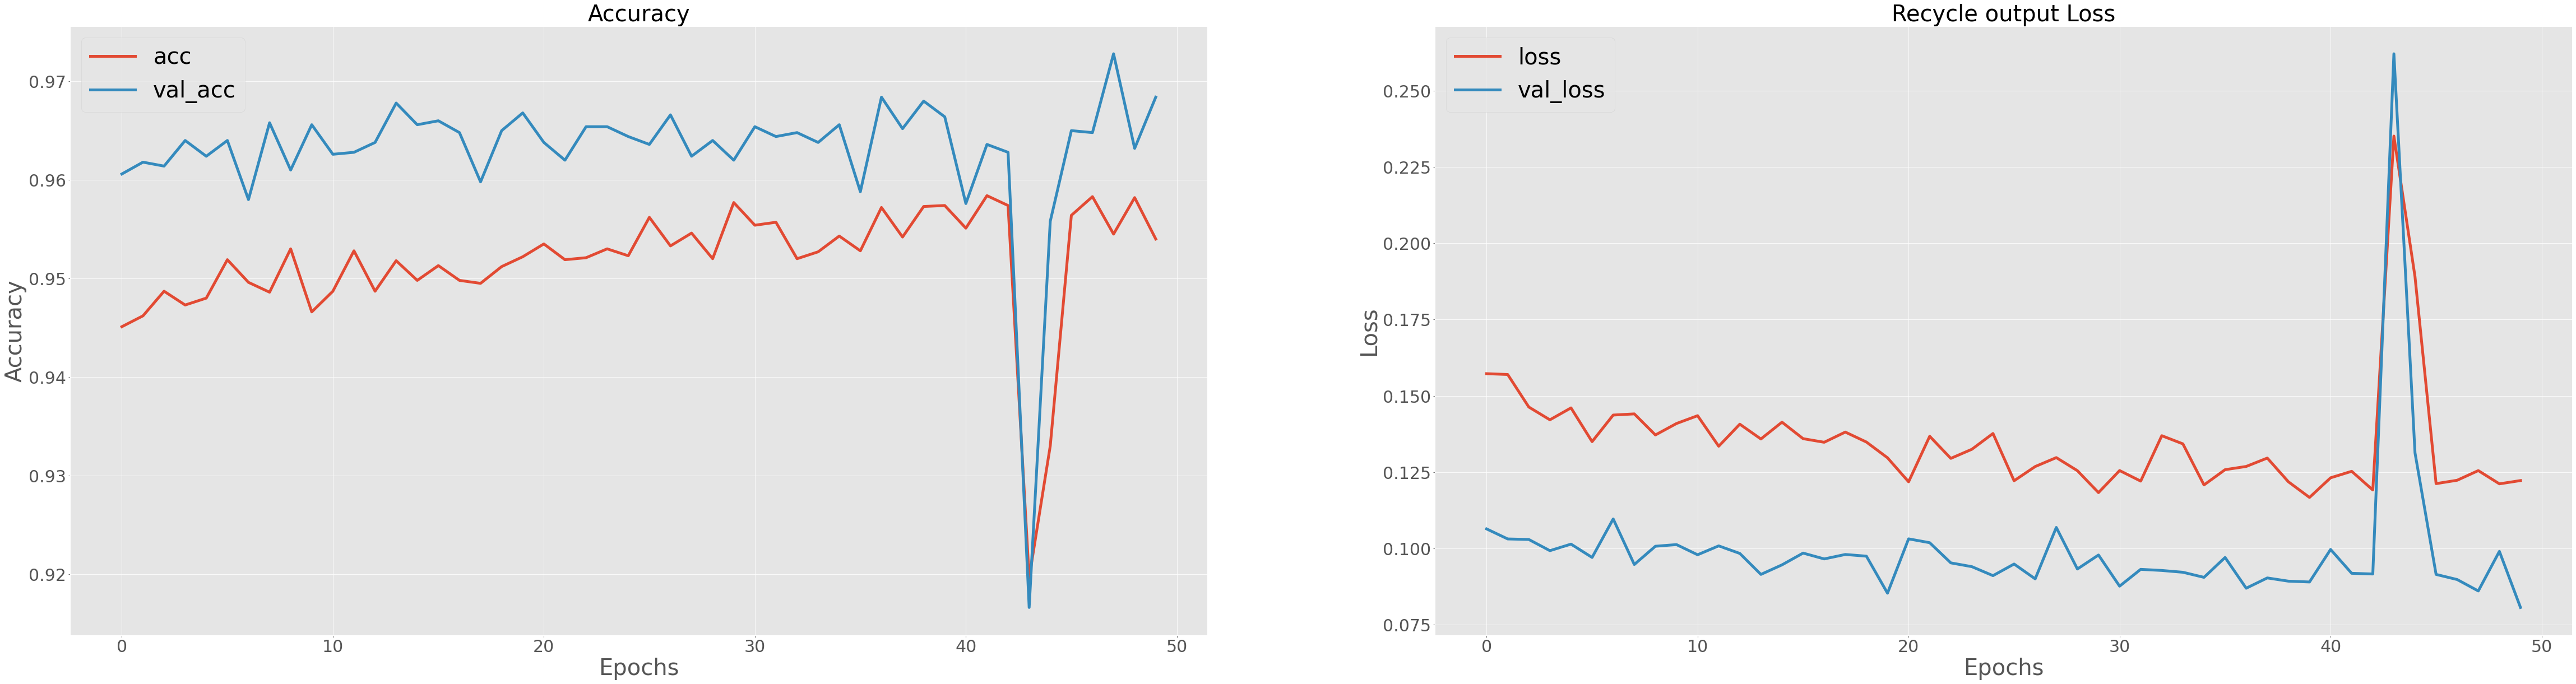

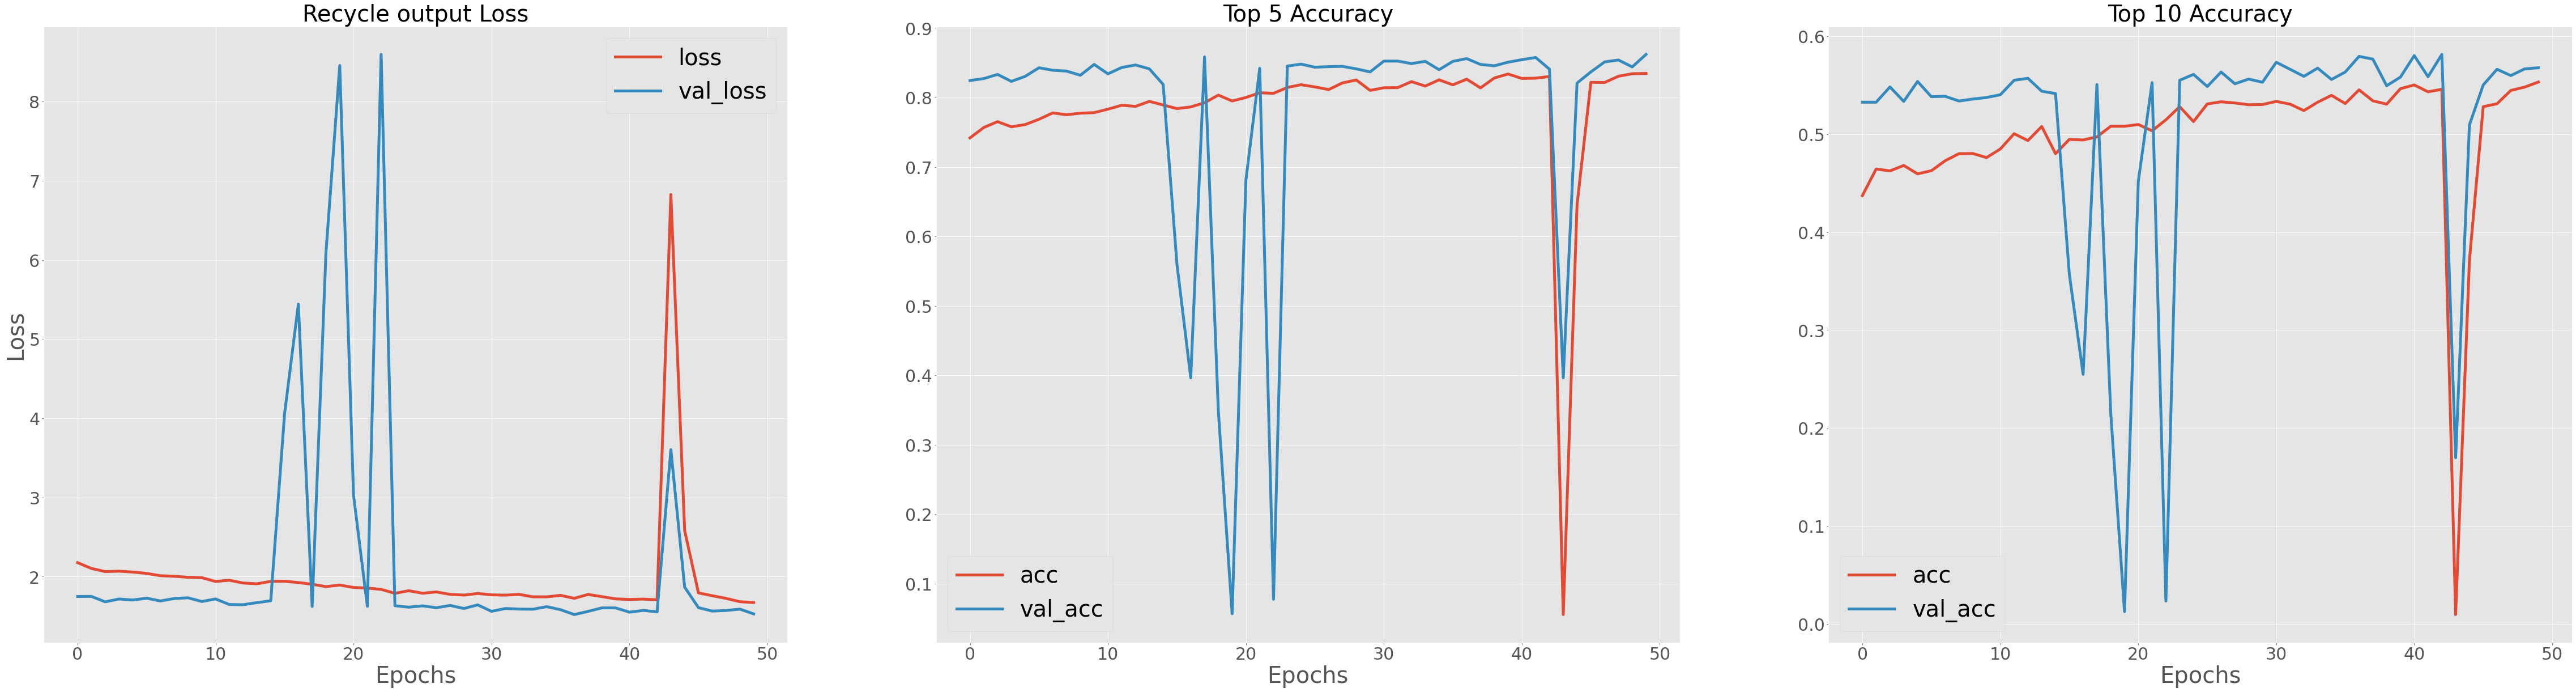

In [64]:
History=np.load(save_history_path ,allow_pickle='TRUE').item()
#History.keys()

plt.style.use("ggplot")
fig,axes = plt.subplots(nrows=1, ncols=2,figsize = (80,20) )

axes[0].plot(History['recycle_output_accuracy'], label = 'acc', linewidth=5)
axes[0].plot(History['val_recycle_output_accuracy'], label='val_acc', linewidth=5)
axes[0].tick_params(labelsize=30)
axes[0].set_title('Accuracy', fontsize=40)
axes[0].set_xlabel("Epochs", fontsize=40)
axes[0].set_ylabel("Accuracy", fontsize=40)
axes[0].legend(fontsize=40)

axes[1].plot(History['recycle_output_loss'], label = 'loss', linewidth=5)
axes[1].plot(History['val_recycle_output_loss'], label='val_loss', linewidth=5)
axes[1].tick_params(labelsize=30)
axes[1].set_title('Recycle output Loss', fontsize=40)
axes[1].set_xlabel("Epochs", fontsize=40)
axes[1].set_ylabel("Loss", fontsize=40)
axes[1].legend(fontsize=40)
fig.savefig(save_plot_path1)

fig,axes = plt.subplots(nrows=1, ncols=3,figsize = (80,20) )

axes[1].plot(History['class_output_sparse_top_5_categorical_accuracy'], label = 'acc', linewidth=5)
axes[1].plot(History['val_class_output_sparse_top_5_categorical_accuracy'], label='val_acc', linewidth=5)
axes[1].tick_params(labelsize=30)
axes[1].set_title('Top 5 Accuracy', fontsize=40)
axes[1].set_xlabel("Epochs", fontsize=40)
axes[1].legend(fontsize=40)

axes[2].plot(History['class_output_accuracy'], label = 'acc', linewidth=5)
axes[2].plot(History['val_class_output_accuracy'], label='val_acc', linewidth=5)
axes[2].tick_params(labelsize=30)
axes[2].set_title('Top 10 Accuracy', fontsize=40)
axes[2].set_xlabel("Epochs", fontsize=40)
axes[2].legend(fontsize=40)

axes[0].plot(History['class_output_loss'], label = 'loss', linewidth=5)
axes[0].plot(History['val_class_output_loss'], label='val_loss', linewidth=5)
axes[0].tick_params(labelsize=30)
axes[0].set_title('Recycle output Loss', fontsize=40)
axes[0].set_xlabel("Epochs", fontsize=40)
axes[0].set_ylabel("Loss", fontsize=40)
axes[0].legend(fontsize=40)



fig.savefig(save_plot_path2)

plt.show()